<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
# Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
# Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [381]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [382]:
# Load the data
house = pd.read_csv('./housing.csv')

In [383]:
# A:
house.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [384]:
fixed_list = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
              'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
              'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
              'HouseStyle', 'YearBuilt', 'Foundation', 'BsmtQual',  'TotalBsmtSF',
              'LowQualFinSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
              'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
              'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageCars',
              'GarageArea']

renov_list = ['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
              'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 
              'ExterCond', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 
              'BsmtFinSF2', 'BsmtFinType2', 'BsmtUnfSF', 'Heating', 'HeatingQC', 
              'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
              'GarageFinish', 'GarageQual', 'ScreenPorch', 'GarageCond', 'PavedDrive', 
              'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'PoolArea', 
              'PoolQC', 'Fence', 'MiscFeature', 'MiscVal']

extra = ['MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']

len(fixed_list) + len(renov_list) + len(extra)

80

In [385]:
# Getting a subset of only residential, determined by MSZoning
res = house[house.MSZoning.str.contains('R')]

In [386]:
res.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [387]:
res.shape

(1385, 81)

In [388]:
res.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1385.000000,1385.000000,1134.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1380.000000,1385.000000,...,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,732.506137,55.328520,70.583774,10706.158845,6.063538,5.607942,1970.048375,1984.121300,102.768841,450.666426,...,96.589170,43.865704,22.547292,3.594224,15.662094,2.908303,45.400722,6.314079,2007.810830,180136.283032
std,422.536319,40.883271,24.251032,10185.732173,1.373366,1.125799,29.831024,20.554236,174.373232,459.231291,...,126.994291,63.585425,62.067644,30.090182,56.883779,41.246294,509.097441,2.695583,1.326813,79906.363281
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,365.000000,20.000000,60.000000,7711.000000,5.000000,5.000000,1953.000000,1966.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129000.000000
50%,734.000000,50.000000,70.000000,9591.000000,6.000000,5.000000,1971.000000,1992.000000,0.000000,387.000000,...,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,1101.000000,70.000000,80.000000,11751.000000,7.000000,6.000000,1999.000000,2003.000000,168.000000,719.000000,...,169.000000,64.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,212900.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [389]:
res.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

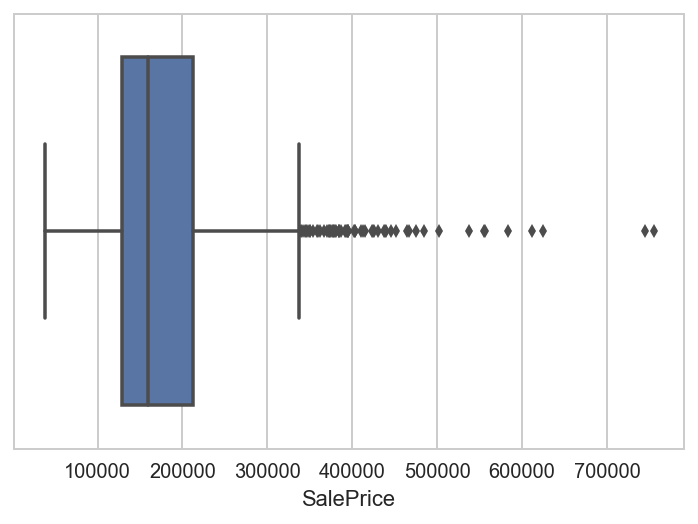

In [390]:
# Some preliminary EDA
# Checking Salesprice to see if any outliers exist
sns.boxplot(res.SalePrice)

In [391]:
# A bunch of points lie outside the IQR, but most specifically are two points greater than $700k
res[res.SalePrice > 700000].T.head(19)

,691,1182
Id,692,1183
MSSubClass,60,60
MSZoning,RL,RL
LotFrontage,104,160
LotArea,21535,15623
Street,Pave,Pave
Alley,NaN,NaN
LotShape,IR1,IR1
LandContour,Lvl,Lvl
Utilities,AllPub,AllPub


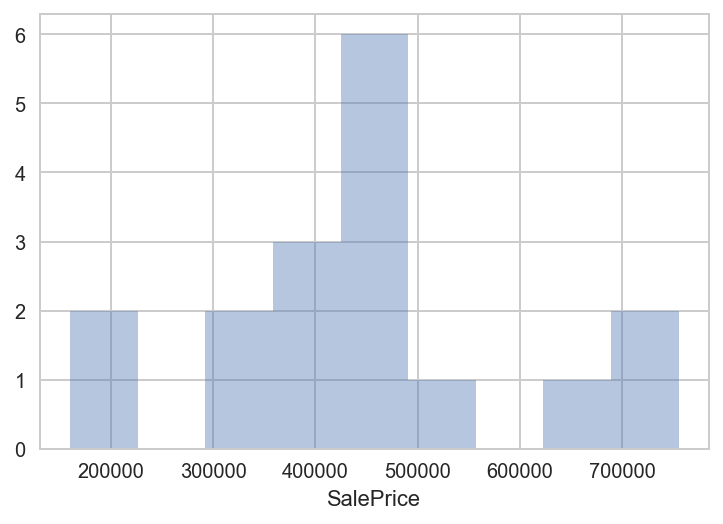

In [392]:
# They're very expensive houses. And may deservedly be so, but they may throw our model off. Let's see if
# other houses with overall quality rating of 10 cost about the same.
sns.distplot(res[res.OverallQual == 10].SalePrice, kde=False)

# It seems like most of the other houses fell in the $400-$500k range. So I am going to take these two houses off out.
res = res[res.SalePrice < 700000]

In [393]:
# Make a subset based on FIXED characteristics
fixed_sub = res.ix[:,fixed_list]

In [394]:
fixed_sub.isnull().sum()

MSSubClass         0
MSZoning           0
LotFrontage      251
LotArea            0
Street             0
Alley           1318
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
BldgType           0
HouseStyle         0
YearBuilt          0
Foundation         0
BsmtQual          37
TotalBsmtSF        0
LowQualFinSF       0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageType        79
GarageYrBlt       79
GarageCars         0
GarageArea         0
dtype: int64

In [395]:
# Make a merged df that will return dummy features for categorical values

def dummy_maker(df):
    cat_dict = {}
    for i in df.columns:
        if len(df[i].value_counts()) < 50 and df[i].dtype == object:
            cat_dict[i] = df[i].value_counts(dropna=False).index
    
    new_df = pd.concat([df,pd.get_dummies(df[cat_dict.keys()], dummy_na=True)], axis=1)
    new_df.drop(cat_dict.keys(), axis=1, inplace=True)
    new_df.drop(new_df.ix[:,new_df.sum()==0].columns, axis=1, inplace=True)
    return new_df
#     return cat_dict

# Not the best looking df, but gives me what I want.
fixed_df = dummy_maker(fixed_sub)


# # using the keys to get only categorical values. Changing into numbers, and then adding 1 (because NaN returns -1)
# test = res.loc[:,cat_dict.keys()].apply(lambda x: x.astype('category'))
# test = test[test.select_dtypes(['category']).columns].apply(lambda x: x.cat.codes)
# test = test.applymap(lambda x: x+1)

70.0
0.818510484454


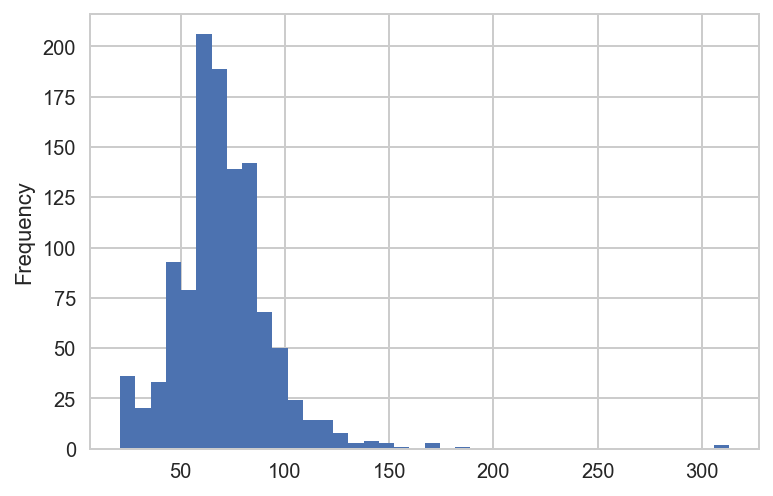

In [396]:
# Imputing the values for LotFrontage based on the median after looking at graph, which looks pretty normal.
fixed_df.LotFrontage.plot(kind='hist', bins=40)

print fixed_df.LotFrontage.median()

print 1. - fixed_df.LotFrontage.isnull().sum()/float(fixed_df.shape[0])

fixed_df.ix[fixed_df.LotFrontage.isnull(), 'LotFrontage'] = fixed_df.LotFrontage.median()

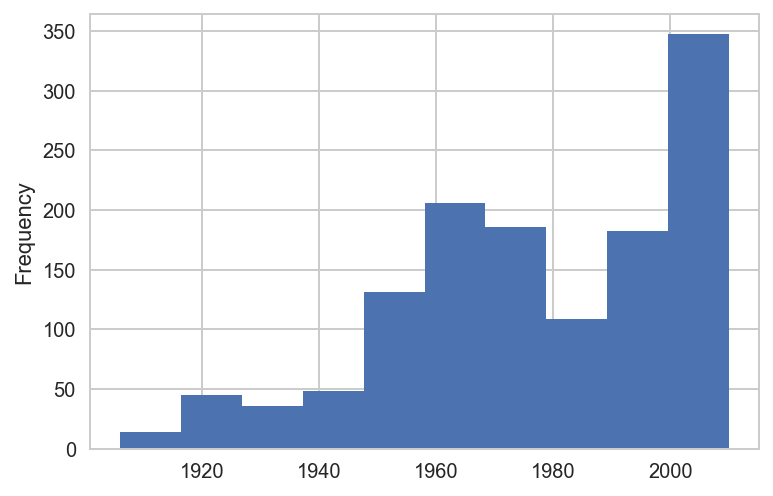

In [397]:
# Imputing values for GarageYrBlt

fixed_df.GarageYrBlt.plot(kind='hist')

0.740419378163


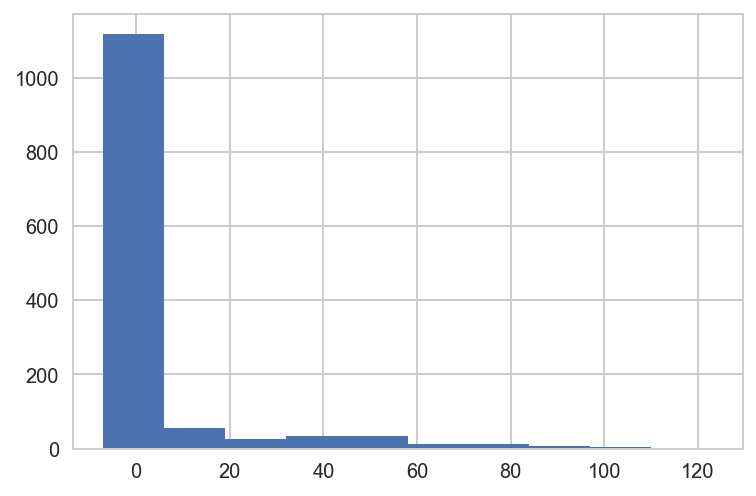

In [398]:
# Garage Yr Blt is a bigger range, so some 'smart' imputing will have to be done
plt.hist(fixed_df[~fixed_df.GarageYrBlt.isnull()].GarageYrBlt - fixed_df[~fixed_df.GarageYrBlt.isnull()].YearBuilt)

# Counting how many obsv have the same garage and year built out of all obsv
print fixed_df[fixed_df.GarageYrBlt == fixed_df.YearBuilt].GarageYrBlt.count() / float(fixed_df.shape[0])

# Since almost 75% of the obsv have the same garage year and year built, the imputed values for GarageYrBlt = YearBuilt
fixed_df.ix[fixed_df.GarageYrBlt.isnull(), 'GarageYrBlt'] = fixed_df.ix[fixed_df.GarageYrBlt.isnull(), 'YearBuilt']

In [399]:
# Last check for nulls in the fixed characteristics
fixed_df.isnull().sum().sum()

0

In [400]:
# Doing a correlation matrix to find initial relationships between target and fixed predictors
X_with_target = fixed_df.join(res.SalePrice)

# As practice, will use the top 50 absolute predictors
col = abs(X_with_target.corr().SalePrice).sort_values(ascending=False).head(51)
col = col.ix[1:]
col_list = col.index

# Getting target variable
y = res.SalePrice

y_train = y.ix[res.YrSold < 2010]
y_test = y.ix[res.YrSold == 2010]

# Standardizing X variable
from sklearn.preprocessing import StandardScaler

X = fixed_df[col_list]

X_train = X.ix[res.YrSold < 2010]
X_test = X.ix[res.YrSold == 2010]

ss = StandardScaler()
Xs = ss.fit_transform(X_train)

In [401]:
# Trying first model: Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)

Xs_test = ss.transform(X_test)

scores = np.mean(cross_val_score(linreg, Xs_test, y_test, cv=5))
print scores

0.754192478024


In [402]:
# 50 predictors is most likely too much. Performing lasso regression to limit the amount of predictors
from sklearn.linear_model import LassoCV

las = LassoCV(n_alphas=50, cv=10)
las.fit(X_train, y_train)
coeffs = las.coef_
las_score = las.score(X_test, y_test)
las_alpha = las.alpha_
print las_score, las_alpha
# Lasso regression improved the score.

# After lasso regression, only 6 predictors last.
lasso_df = pd.DataFrame([coeffs, col_list], index=['Coeffs', 'Variable']).T
lasso_df = lasso_df[lasso_df.Coeffs !=0]
new_col = lasso_df.Variable.values

# The best predictors are:
print 'Best predictors based on lasso are:', new_col

0.740029835975 215641.823764
Best predictors based on lasso are: ['GrLivArea' 'GarageArea' 'TotalBsmtSF' 'YearBuilt' '2ndFlrSF' 'LotArea']


0.750624959789


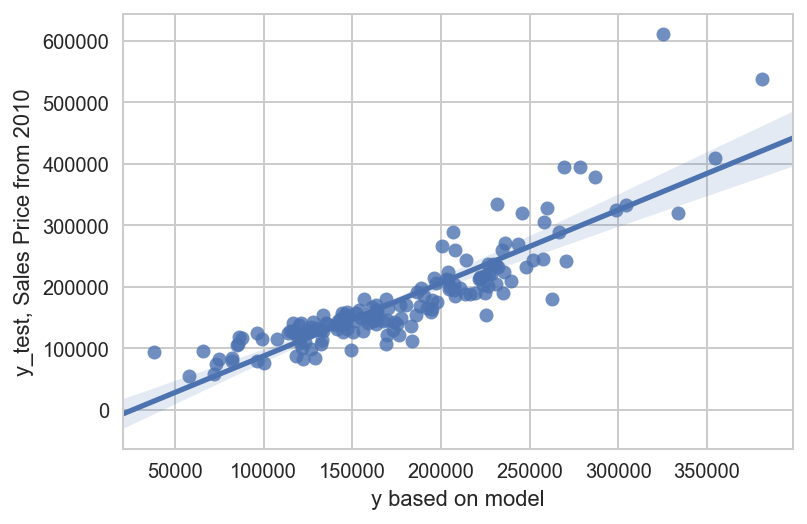

In [403]:
new_Xtr = X_train[[c for c in new_col]]
new_Xte = X_test[[c for c in new_col]]
new_lm = LinearRegression()
new_lm.fit(new_Xtr, y_train)
yhat = new_lm.predict(new_Xte)

sns.regplot(x=yhat, y=y_test)
plt.xlabel('y based on model')
plt.ylabel('y_test, Sales Price from 2010')

print new_lm.score(new_Xte, y_test)

In [404]:
# Seeing if those features were the best features to choose based on feature selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif

selection = SelectKBest(f_classif, k=6)
selection.fit_transform(X_train, y_train)
sel_arr = selection.get_support()
f_col = X_train.columns.values[sel_arr]

chi_selection = SelectKBest(chi2, k=6)
chi_selection.fit_transform(X_train, y_train)
chi_sel_arr = selection.get_support()
chi_col = X_train.columns.values[chi_sel_arr]

print f_col, chi_col

['GrLivArea' 'GarageCars' 'BsmtQual_Ex' 'Neighborhood_NridgHt'
 'Neighborhood_NoRidge' 'LotArea'] ['GrLivArea' 'GarageCars' 'BsmtQual_Ex' 'Neighborhood_NridgHt'
 'Neighborhood_NoRidge' 'LotArea']


In [405]:
Xtr_f = X_train[[c for c in f_col]]
Xte_f = X_test[[c for c in f_col]]
lm = LinearRegression()
lm.fit(Xtr_f, y_train)
yhat_f = lm.predict(Xte_f)

print 'F_class feature selection score is:', new_lm.score(Xte_f, y_test)

Xtr_chi = X_train[[c for c in chi_col]]
Xte_chi = X_test[[c for c in chi_col]]
lm = LinearRegression()
lm.fit(Xtr_chi, y_train)
yhat_chi = lm.predict(Xte_chi)

print 'Chi2 feature selection score is:', new_lm.score(Xte_chi, y_test)

F_class feature selection score is: -313.773575623
Chi2 feature selection score is: -313.773575623


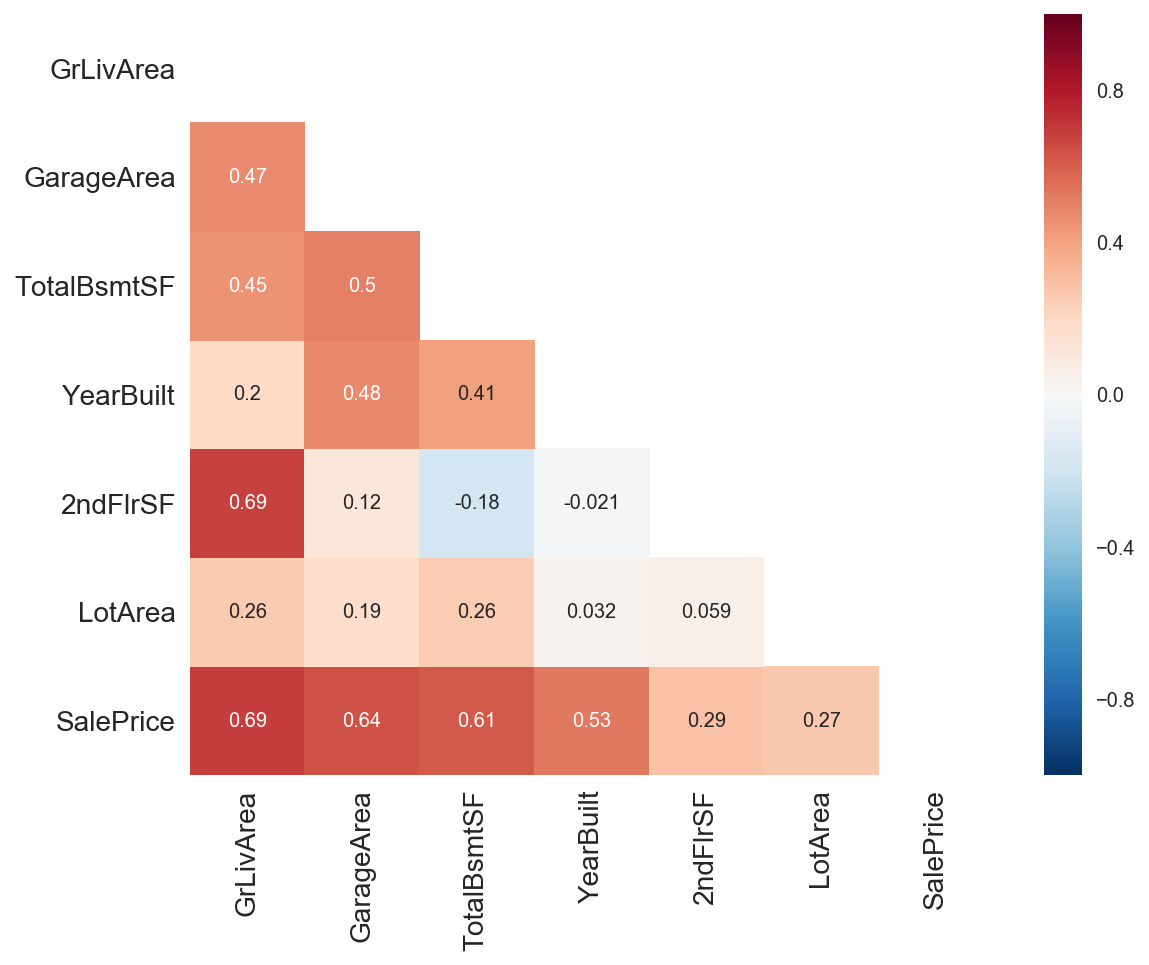

In [406]:
# Set init variables
heatmap_col = new_col.tolist()
heatmap_col.append('SalePrice')
df = X_with_target[heatmap_col]
corr = df.corr()

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, annot=True, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation='vertical')
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [407]:
# A:
# Getting yhat of training set
new_Xtr = X_train[[c for c in new_col]]
new_lm = LinearRegression()
new_lm.fit(new_Xtr, y_train)
yhat_tr = new_lm.predict(new_Xtr)

# making two residual df. One of train and one of test
resid_train = yhat_tr - y_train
resid_test = yhat - y_test
resid = pd.concat([resid_train, resid_test])
resid.sort_index(inplace=True)
resid.describe()

count      1383.000000
mean       -235.963102
std       41624.158320
min     -286533.635185
25%      -14784.774889
50%        3704.444890
75%       19606.107000
max      556085.393602
Name: SalePrice, dtype: float64

In [408]:
# EDA on the dataset.
renov_sub.describe()

,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,ScreenPorch,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,PoolArea,MiscVal,Residual
count,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000,1378.000000
mean,6.052975,5.611756,1984.055878,102.068940,446.846880,49.319303,563.058781,15.741655,96.312772,43.611756,22.516691,3.612482,2.520319,45.631350,-184.752277
std,1.363262,1.125814,20.574266,172.089741,456.036668,165.640912,443.809165,57.017191,126.842391,63.372934,62.023317,30.165473,38.579309,510.379485,41408.781659
min,1.000000,1.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-286533.635185
25%,5.000000,5.000000,1966.000000,0.000000,0.000000,0.000000,216.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14796.407807
50%,6.000000,5.000000,1992.000000,0.000000,384.000000,0.000000,471.500000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,3558.794366
75%,7.000000,6.000000,2003.000000,168.000000,713.750000,0.000000,802.500000,0.000000,168.000000,64.000000,0.000000,0.000000,0.000000,0.000000,19607.683706
max,10.000000,9.000000,2010.000000,1378.000000,5644.000000,1474.000000,2336.000000,480.000000,857.000000,547.000000,552.000000,508.000000,738.000000,15500.000000,556085.393602


In [409]:
# Combining target with rest of dataset in case we drop any values
renov_sub['Residual'] = resid

# Checking MasVnrType and MasVnrArea, which are null at the same rows
renov_sub.MasVnrType.value_counts(dropna=False)

# There is already a None category for houses without mason veneers. Since this information won't be able to give
# much info, I'm going to drop these 5 obvs.
renov_sub = renov_sub[~renov_sub.MasVnrType.isnull()]
renov_sub.isnull().sum()

OverallQual         0
OverallCond         0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
MasVnrArea          0
ExterQual           0
ExterCond           0
BsmtCond           37
BsmtExposure       37
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinSF2          0
BsmtFinType2       37
BsmtUnfSF           0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       640
GarageFinish       79
GarageQual         79
ScreenPorch         0
GarageCond         79
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
PoolArea            0
PoolQC           1372
Fence            1102
MiscFeature      1326
MiscVal             0
Residual            0
dtype: int64

In [410]:
# Checking BsmtCond, Exposure and Finish Type1. NA means that the house has no basement. I can't logically take it away
# So it will have to be labeled as a dummy variable. However, there is one value in BsmtExposure that isn't in the others
# There is also an extra BsmtFinType2
renov_sub[(renov_sub.BsmtExposure.isnull()) & (~renov_sub.BsmtCond.isnull())][['BsmtCond', 'BsmtFinType1']]
renov_sub[(renov_sub.BsmtFinType2.isnull()) & (~renov_sub.BsmtCond.isnull())][['BsmtCond', 'BsmtFinType1']]

# Going to use the mode for imputing BsmtExposure & BsmtFinType2
print renov_sub.BsmtExposure.value_counts()
renov_sub.ix[948, 'BsmtExposure'] = 'No'

print renov_sub.BsmtFinType2.value_counts()
renov_sub.ix[332, 'BsmtFinType2'] = 'Unf'

No    894
Av    209
Gd    132
Mn    106
Name: BsmtExposure, dtype: int64
Unf    1175
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


In [411]:
# Perform dummy variable function on renovatable feature set
renov_df = dummy_maker(renov_sub)
renov_df.isnull().sum().sum()

0

In [421]:
# Perform the same operations in previous example except with different y and X matrices

# Doing a correlation matrix to find initial relationships between target and fixed predictors
# As practice, will use the top 50 absolute predictors
renov_df.corr().Residual
col = abs(renov_df.corr().Residual).sort_values(ascending=False).head(51)
col = col.ix[1:]
col_list = col.index

# Getting target variable
y = renov_df.Residual

y_train = y.ix[res.YrSold < 2010]
y_test = y.ix[res.YrSold == 2010]

# Standardizing X variable

X = renov_df[col_list]

X_train = X.ix[res.YrSold < 2010]
X_test = X.ix[res.YrSold == 2010]

ss = StandardScaler()
Xs = ss.fit_transform(X_train)

In [422]:
# Trying first model: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

Xs_test = ss.transform(X_test)

scores = np.mean(cross_val_score(linreg, Xs_test, y_test, cv=5))
print scores

0.512325221077


In [427]:
# Pretty bad score using the top 50 largets absolute correlations. Going to use lasso again to hopefully
# eliminate non-essential predictors

las = LassoCV(n_alphas=50, cv=10)
las.fit(X_train, y_train)
coeffs = las.coef_
las_score = las.score(X_test, y_test)
las_alpha = las.alpha_
print las_score, las_alpha
# Lasso regression improved the score.

# After lasso regression, only 6 predictors last.
lasso_df = pd.DataFrame([coeffs, col_list], index=['Coeffs', 'Variable']).T
lasso_df = lasso_df[lasso_df.Coeffs !=0]
new_col = lasso_df.Variable.values

0.217735246569 1242.89212325


In [442]:
# LassoCV score is actually lower than regular cv-MLR. Going to use ElasticNet in a gridsearch
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV

en_param = {
    'l1_ratio':[0.25, 0.5, 0.75, 1],
    'n_alphas':[5, 10, 25, 50, 75, 100]
}

gs = GridSearchCV(ElasticNetCV(), en_param, cv=10)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'l1_ratio': [0.25, 0.5, 0.75, 1], 'n_alphas': [5, 10, 25, 50, 75, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [444]:
gs.best_params_
gs.best_score_

0.18943081254704267

In [452]:
# Seeing if those features were the best features to choose based on feature selection
selection = SelectKBest(f_classif, k=6)
selection.fit_transform(X_train, y_train)
sel_arr = selection.get_support()
f_col = X_train.columns.values[sel_arr]

# chi_selection = SelectKBest(chi2, k=6)
# chi_selection.fit_transform(X_train, y_train)
# chi_sel_arr = selection.get_support()
# chi_col = X_train.columns.values[chi_sel_arr]

# print f_col, chi_col

In [453]:
Xtr_f = X_train[[c for c in f_col]]
Xte_f = X_test[[c for c in f_col]]
lm = LinearRegression()
lm.fit(Xtr_f, y_train)
yhat_f = lm.predict(Xte_f)

print 'F_class feature selection score is:', new_lm.score(Xte_f, y_test)

# Xtr_chi = X_train[[c for c in chi_col]]
# Xte_chi = X_test[[c for c in chi_col]]
# lm = LinearRegression()
# lm.fit(Xtr_chi, y_train)
# yhat_chi = lm.predict(Xte_chi)

# print 'Chi2 feature selection score is:', new_lm.score(Xte_chi, y_test)

F_class feature selection score is: -1098.29440272


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [26]:
# A: